In [3]:
using PyPlot, LsqFit, Polynomials, Random, Statistics

# Numerical many-body methods - Problem Set 4 
## (Classical Monte Carlo)
Noam Ophir

# 2D XY model and the Kosterlitz-Thouless transition

*In this exercise we will consider the 2D XY model on a square lattice. Consider a spin of unit length pointing within the $x-y$ plane at each site of the lattice, and denote by $\theta_i$ the direction of the spin on site $i$. The energy of the system is given by*

$$H=-J\sum_{\langle i,j\rangle} \cos(\theta_i-\theta_j)$$

*where the summation $\langle i,j\rangle$ is over nearest neighbors on the lattice. We will assume $J > 0$.*

*Since in 2D a continuous symmetry can not be spontaneously broken at finite temperature (due to Mermin-Wagner theorem) there is no conventional ordering phase transition as the temperature is lowered. However, the model does exhibit a transition from a fully disordered phase at high temperatures (in which spin correlations decay exponentially) to a quasi-ordered state at low temperatures (in which the decay of spin correlations obeys a power law). This transition is known as the Kosterlitz-Thouless transition, and can be understood in terms of proliferation of vortices at high temperatures: in the low temperature phase vortices are bound into vortex-antivortex pairs, while at high temperatures the vortices and antivortices become free. The transition between these two phases occurs at a temperature $T_{KT}$ that you will determine in this exercise.*

*We'll start with generalizing the Wolf algorithm we discussed for the Ising model to the case of spins that can point in an arbitrary direction in an $N$-dim space, i.e. $\vec{S}_i\in O(N)$. (For the XY case we have $N = 2$.) This is done by considering a projection of all the spins in the system onto a random direction and then using the Ising cluster algorithm for this projected state. Denoting the random direction by $\hat{e}$, two spins $\vec{S}_i,\;\vec{S}_j$ are now connected with probability*

$$p=1-e^{\mathrm{min}(0,-2\beta J (\vec{S}_i\cdot \hat{e})(\vec{S}_j\cdot \hat{e})}\;.$$

*Note that here $\vec{S}_i\cdot \hat{e}$ is simply the component of $\vec{S}_i$ along the direction $\hat{e}$. If these components are anti-aligned for the two spins $i,j$, then these two spins will never be connected (similarly to anti-aligned spins in the Ising case). In the Wolf algorithm a cluster is then constructed similarly to the Ising case starting from a random spin on the lattice. The update is done by flipping the projections of the spins in the cluster onto the direction $\hat{e}$, i.e. $\vec{S}_i\mapsto \vec{S}_i - 2(\vec{S}_i\cdot \hat{e})\hat{e}$.*

## 1
*Implement the Monte Carlo algorithm using Wolf cluster updates for the XY model in 2D.*

In [57]:
### Tutorial functions
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

NearestNeighbors (generic function with 1 method)

In [97]:
function XYConfigurationEnergy(lat::SquareLattice, config::Vector{Float64})
    
    N = length(lat)
    @assert N == length(config) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        Ec +=  -sum(cos.(config[j] .- config[nn]))
    end
    return Ec/2 # in the summation above every bond is included twice
end

XYConfigurationEnergy (generic function with 7 methods)

In [111]:
function XYWolffUpdate!(lat::SquareLattice, config::Vector{Float64}, T::Float64)
    # Get the lattice size
    N = length(lat)
    
    # Check if the configuration size matches the lattice size
    @assert N == length(config) "Configuration incompatible with lattice size"
    
    # Pick a random site
    ind = rand(1:N)
    
    # Arrays to store cluster indices and newly added neighbors
    cluster = Int64[] 
    newlyAdded = Int64[] 
    
    # Add the selected site to the cluster and its neighbors to newlyAdded
    push!(cluster, ind)
    append!(newlyAdded, NearestNeighbors(lat, ind))
    
    # Perform the Wolff algorithm until the cluster is empty
    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        
        # Skip if already in the cluster
        if j in cluster
            continue
        end
        
        # If random number is less than p, add to cluster
        if rand() < 1. - exp(-2 * cos(config[j]) * cos(config[ind])/ T)
            push!(cluster, j)
            
            # Add neighbors of the current site to newlyAdded
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
        end
    end
    
    # flipping the projections of the spins in the cluster onto the direction x
    config[cluster] .= (pi .- config[cluster]) .% (2*pi)
end

function XY_MC(lat::SquareLattice, T::Float64, Nsw::Int64; saveConfigs = false)
    """
    Perform XY model Monte Carlo simulations using Wolf algorithm.

    Parameters:
    `lat`: SquareLattice object representing the lattice.
    `T`: Temperature.
    `Nsw`: Number of sweeps to perform.
    `clusterUpdates`: Perform cluster updates if true, single-spin updates if false.
    `saveConfigs`: Save configurations at each sweep if true.
    """
    config = rand(length(lat))*2*pi  # Initialize random spin configuration.

    if saveConfigs
        configs = zeros(Int64, Nsw, length(lat))  # Matrix to store configurations at each sweep.
        configs[1, :] = config  # Save initial configuration.
    end

    En = zeros(Float64, Nsw)  # Array to store energy at each sweep.
   
    En[1] = XYConfigurationEnergy(lat, config)  # Initial energy.
    
    for i in range(2, stop=Nsw)  # Loop over sweeps.
        
        XYWolffUpdate!(lat, config, T)  # Perform cluster update.
        En[i] = XYConfigurationEnergy(lat, config)  # Calculate new energy.

        
        if saveConfigs
            configs[i, :] = config  # Save current configuration.
        end

        # m[i] = abs(mean(2 * c .- 1))  # Update magnetization.

    end
    if saveConfigs
        return  En, configs
    else
        return En, config
    end
    
end

XY_MC (generic function with 2 methods)

In [114]:
lat = SquareLattice(36,36)
T = 2.2
Nsw = 100000
# print(config)
@time En, config = XY_MC(lat, T, Nsw);


100000 35.431205 seconds (389.61 M allocations: 34.830 GiB, 18.70% gc time)


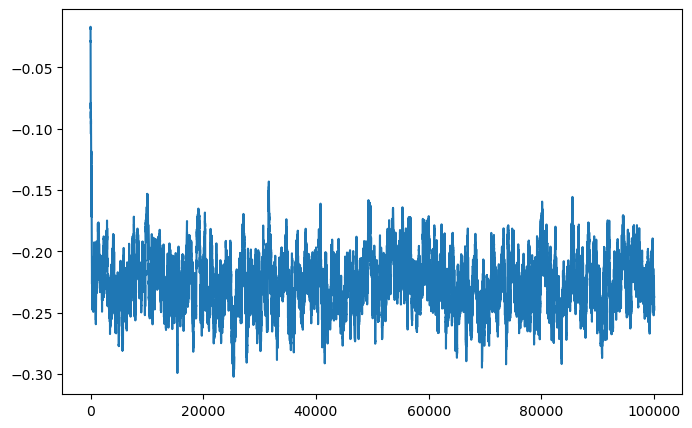

In [118]:
fig,ax = subplots(figsize=(8,5))
ax.plot(En ./ length(lat))

gcf()



## 2
*Check autocorrelation and equilibration times for systems up to $32\times32$ sites in the low temperature regime (e.g. $T=0.1$), close to the phase trasition (e.g. $T=1$), and in the high temperature regime (e.g. $1.5$). Plot sample configurations at each temperature and check whether they agree qualitatively with what you would expect. (If you are using PyPlot you can use `imshow` to plot a 2D image corresponding to the configuration. Tip: use a cyclic `colormap` such as `"hsv"` so that  $\theta=0$ and $\theta=2\pi$ are shown with the same color.)*

## 3

*Calculate the spin-spin correlation function $C(|i-j|)=\langle \cos(\theta_i-\theta_j) \rangle$ (for simplicity you can calculate the correlations along the $x$- and/or $y$-directions, or consider their average) for a system of size $32\times32$. Show that at low temperatures the correlations obey a power law (what is the exponent as $T \rightarrow 0$?), while at high temperatures the decay is exponential.*

*An important characteristic of the KT transition is a discontinuity in the spin stiffness at the point of the transition. (The discontinuity will of course occur only in the thermodynamic limit and will be smoothed for  nite systems.)*

*Spin stiffness, $\rho_s$, is a quantity that characterizes the tendency of ordered spins to adapt in response to perturbations imposing modulations of the direction of the order parameter. When spins are ordered (or quasi-ordered as in the XY 2D case) $\rho_s$ is finite, while in the disordered phase $\rho_s=0$. The spin stiffness is defined as*

$$\rho_s=\frac{1}{N}\frac{\partial^2 F}{\partial \phi^2}=-\frac{1}{2N}\left( \langle E \rangle +\frac{1}{T} \Big( \left< I_x^2\right>^2+\left< I_y^2\right>^2 \Big)\right)$$

*where $F(\phi)$ is the free energy in presence of a twist field that imposes a twist $\phi$ on the spins, $N$ is the total number of spins in the system and $I_{a=x,y}$ are spin currents along the $a = x, y$ direction, defined as*

$$I_a = \sum_{\left<i,j\right>_a} \sin(\theta_i-\theta_j)$$
*where $\left<i,j\right>_a$ denotes nearest neighbors along $a = x, y$. (See Sandvik's review Chapter 3.5 for more details.)*

## 4
*Calculate the spin stiffness as a function of temperature, in a temperature range between $T=0.1$ and $T=2.0$, for system sizes $L = 4, 8, 16$ (where $L$ is the linear systems size, i.e. the total number of sites is $N = L^2$). Check that at $T \rightarrow 0$, $\rho_S \rightarrow1$, and that at large $T$, $\rho_S \rightarrow0$. You should be able to see that the drop in the spin stiffness is becoming more abrupt with increasing $L$ (i.e. as we are approaching the thermodynamic limit).*

## 5
*To obtain TKT we will follow the procedure used in Ref. [Phys. Rev. B 37, 5986(R) (1988)]. From the RG analysis of the KT transition, it is known that as $T \rightarrow T_{KT}$*

$$\rho_s(L) = \rho_s^\infty \left( 1 + \frac{1}{2} \frac{1}{\log(L)+C}\right)\;,$$

*where $\rho_s^\infty=2T_{KT}/\pi$ is the jump in the spin stiffness in at the transition point in the thermodynamic limit, and $C$ is an undetermined constant. Consider temperatures close to the phase transition (e.g. in the range $T=0.8$ to $1.0$) and for each temperature obtain $\rho_s(L)$ for systems of size $L = 4, 6, 8, 10$. Try to fit $\rho_s(L)$ you obtained to the form*

$$\rho_s(L) = \frac{2}{\pi} T \left( 1 + \frac{1}{2} \frac{1}{\log(L)+C}\right)\;.$$

*Note that for a given temperature the only free parameter in the fit is $C$. Denoting the standard deviation of the fit by $\Delta(T)$ look for the temperature $T$ for which $\Delta(T)$ is minimal. Since we expect this scaling to hold exactly at $T = T_{KT}$, i.e. for $\Delta(T_{KT})$ to vanish (at least once large enough system sizes are considered so that the RG analysis holds), obtaining the temperature at which $\Delta(T)$ is minimal will give us a (surprisingly good, given the system size we used) estimate of $T_{KT}$.*